### Introduction to Models
#### "Why" Models

Will explore _why_ the spiking data observed is produced the way it is.

To understand this will investigate entropy:
- Compute formula for entropy (a measure of information)
- Compute entropy of a number of toy distributions
- Compute entropy of spiking activity from Steinmetz data

#### Setup

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# @title Plotting Functions

def plot_pmf(pmf,isi_range):
  """Plot the probability mass function."""
  ymax = max(0.2, 1.05 * np.max(pmf))
  pmf_ = np.insert(pmf, 0, pmf[0])
  plt.plot(bins, pmf_, drawstyle="steps")
  plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
  plt.title(f"Neuron {neuron_idx}")
  plt.xlabel("Inter-spike interval (s)")
  plt.ylabel("Probability mass")
  plt.xlim(isi_range)
  plt.ylim([0, ymax])

#@title Download Data
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Could not download data')
else:
  steinmetz_spikes = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

#### Optimization and Information
We want to describe our empirical ISI distribution with an equation that comes from optimizing a problem. 

_From a biological standpoint_: To communicate effectively for downstream computation, the neuron would need to make good use of its limited spiking capability. This becomes an optimization problem.

Our question is: What is the optimal way for a neuron to fire in order to maximize its ability to communicate information?

To explore this we define a quantifiable measure of information (entropy) as:
$$
H_{b}(X)=-\sum \limits _{x\in X} p(x)log_{b}p(x)
$$

$H$ is entropy measured of units base $b$ and $p(x)$ is prob of observing event $x$ from the set of all possible events in $X$.

How entropy changes between probavility mass functions (PMF's). Firstly, where all probability mass central to distribution:

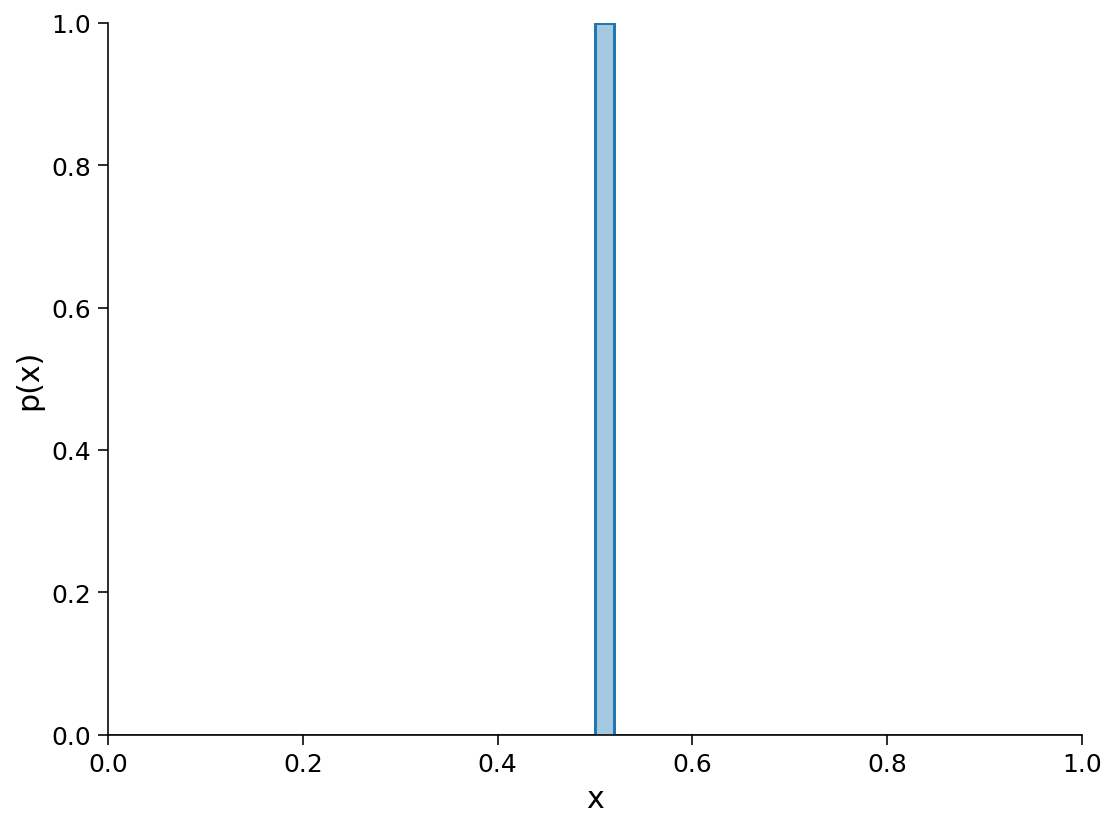

In [2]:
n_bins = 50  # number of points supporting the distribution
x_range = (0, 1)  # will be subdivided evenly into bins corresponding to points

bins = np.linspace(*x_range, n_bins + 1)  # bin edges

pmf = np.zeros(n_bins)
pmf[len(pmf) // 2] = 1.0  # middle point has all the mass

# Since we already have a PMF, rather than un-binned samples, `plt.hist` is not
# suitable. Instead, we directly plot the PMF as a step function to visualize
# the histogram:
pmf_ = np.insert(pmf, 0, pmf[0])  # this is necessary to align plot steps with bin edges
plt.plot(bins, pmf_, drawstyle="steps")
# `fill_between` provides area shading
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1)
plt.show()

This is a deterministic distribution
#### Computing Entropy
Implementing a method that computes entropy of a discrete prob distribution.

In [3]:
def entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits.

  This is a measure of information in the distribution. For a totally
  deterministic distribution, where samples are always found in the same bin,
  then samples from the distribution give no more information and the entropy
  is 0.

  For now this assumes `pmf` arrives as a well-formed distribution (that is,
  `np.sum(pmf)==1` and `not np.any(pmf < 0)`)

  Args:
    pmf (np.ndarray): The probability mass function for a discrete distribution
      represented as an array of probabilities.
  Returns:
    h (number): The entropy of the distribution in `pmf`.

  """

  # reduce to non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf > 0]

  # implement the equation for Shannon entropy (in bits)
  h = -np.sum(pmf*np.log2(pmf))

  # return the absolute value (avoids getting a -0 result)
  return np.abs(h)

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

0.00 bits


0 is expected from a deterministic distribution. (no surprise if only one outcome)

If mass is plit equally between two points such as:

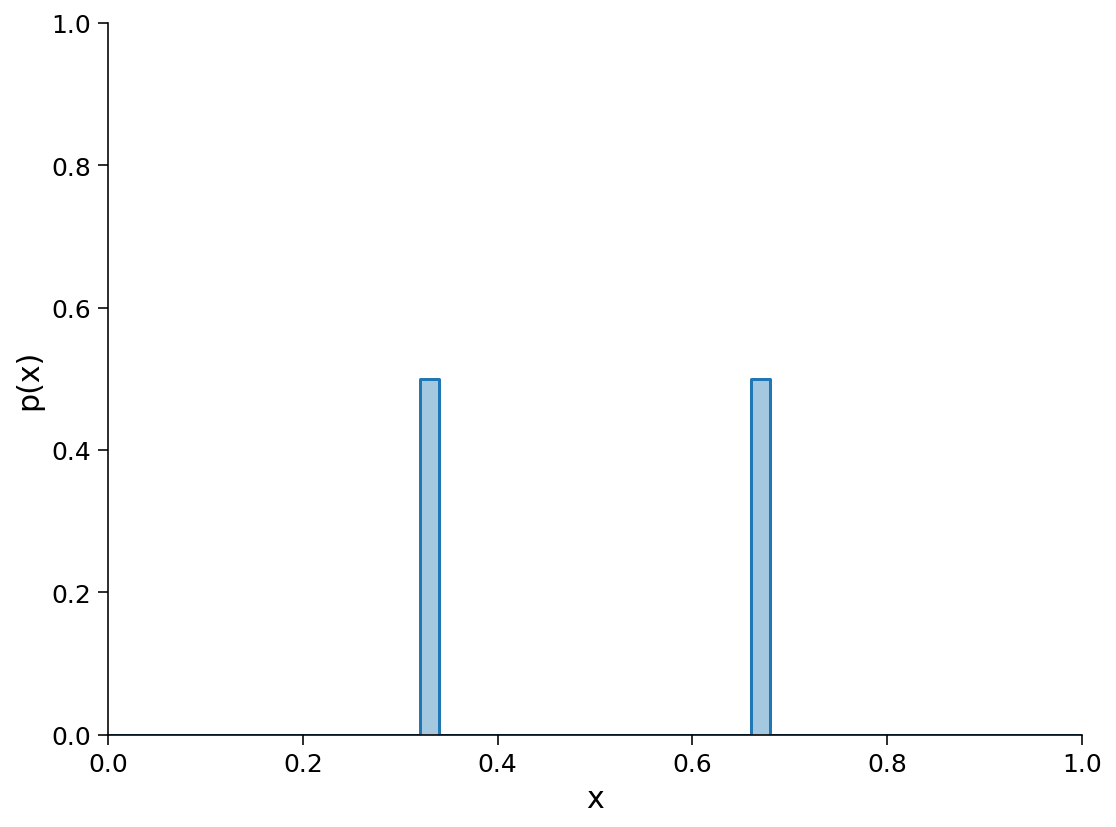

In [4]:
pmf = np.zeros(n_bins)
pmf[len(pmf) // 3] = 0.5
pmf[2 * len(pmf) // 3] = 0.5

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1)
plt.show()

Entropy for this is: $-(0.5log_{2}0.5+0.5log_{2}0.5)=1$

1 bit of entropy, meaning before random sample there is 1 bit of uncertainty about which point in distribution sample will fall on. 
#### Optimization problem
- __Constraint__: Each neuron can only produce a certain number of spikes (energy cost)
- __Objective__: Maximize Entropy of ISI's given fixed number of spikes

Consider three hypothetical neurons that have same ISI but different distributions:
- 1. Deterministic
- 2. Uniform
- 3. Exponential

Fixing the mean of the ISI distribution is equivalent to fixing its inverse: the neuron’s mean firing rate. By fixing the mean firing rate, we are normalizing for energy expenditure.

"In other words: if our neuron has a fixed budget, what ISI distribution should it express (all else being equal) to maximize the information content of its outputs?"

Constructing three different entropies:

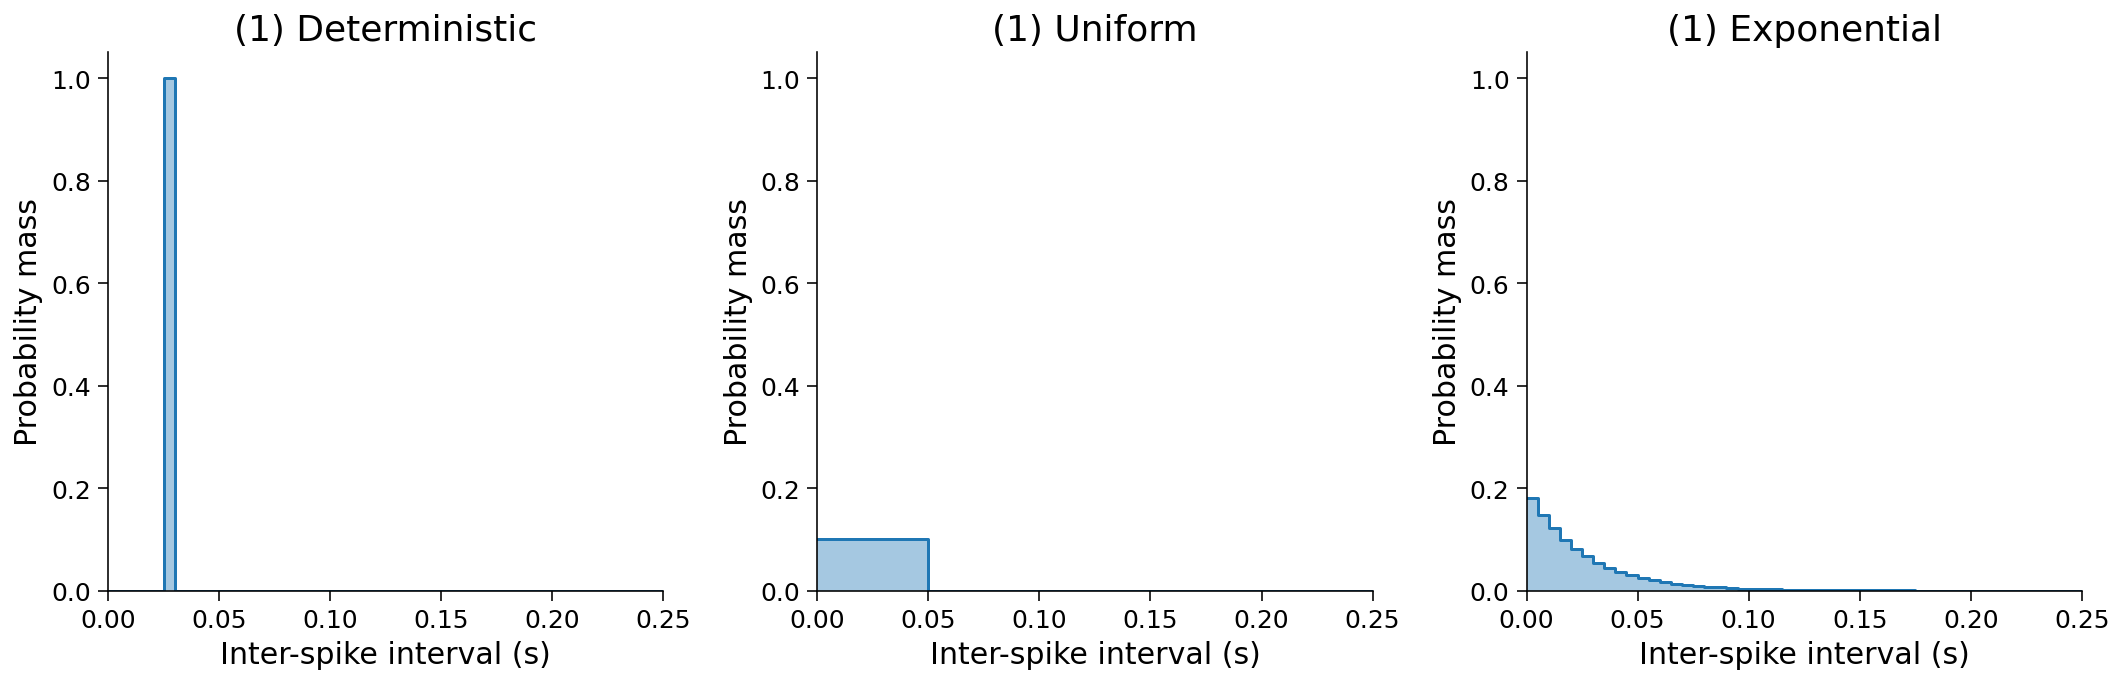

Deterministic: 0.00 bits
Uniform: 3.32 bits
Exponential: 3.77 bits


In [6]:
n_bins = 50
mean_isi = 0.025
isi_range = (0, 0.25)

bins = np.linspace(*isi_range, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

# 1. all mass concentrated on the ISI mean
pmf_single = np.zeros(n_bins)
pmf_single[mean_idx] = 1.0

# 2. mass uniformly distributed about the ISI mean
pmf_uniform = np.zeros(n_bins)
pmf_uniform[0:2*mean_idx] = 1 / (2 * mean_idx)

# 3. mass exponentially distributed about the ISI mean
pmf_exp = stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

dists =  [# (subplot title, pmf, ylim)
          ("(1) Deterministic", pmf_single, (0, 1.05)),
          ("(1) Uniform", pmf_uniform, (0, 1.05)),
          ("(1) Exponential", pmf_exp, (0, 1.05))]

for ax, (label, pmf_, ylim) in zip(axes, dists):
  pmf_ = np.insert(pmf_, 0, pmf_[0])
  ax.plot(bins, pmf_, drawstyle="steps")
  ax.fill_between(bins, pmf_, step="pre", alpha=0.4)
  ax.set_title(label)
  ax.set_xlabel("Inter-spike interval (s)")
  ax.set_ylabel("Probability mass")
  ax.set_xlim(isi_range)
  ax.set_ylim(ylim)
plt.show()

print(
  f"Deterministic: {entropy(pmf_single):.2f} bits",
  f"Uniform: {entropy(pmf_uniform):.2f} bits",
  f"Exponential: {entropy(pmf_exp):.2f} bits",
  sep="\n",
)

#### Calculate entropy of ISI distributions from data

Before was computed by hand, to compute from actual recorded data from neurons convert ISI histograms into discrete prob distributions by:
$$
p_{i}=\frac{n_{i}}{\sum \limits _{i} n_{i}}
$$
Where $p_{i}$ is prob of ISIS falling within particular interval ${i}$ and $n_{i}$ is count of how many ISI's observed in interval.

To verify, compute prob distribution of ISI's from Steinmetz data:

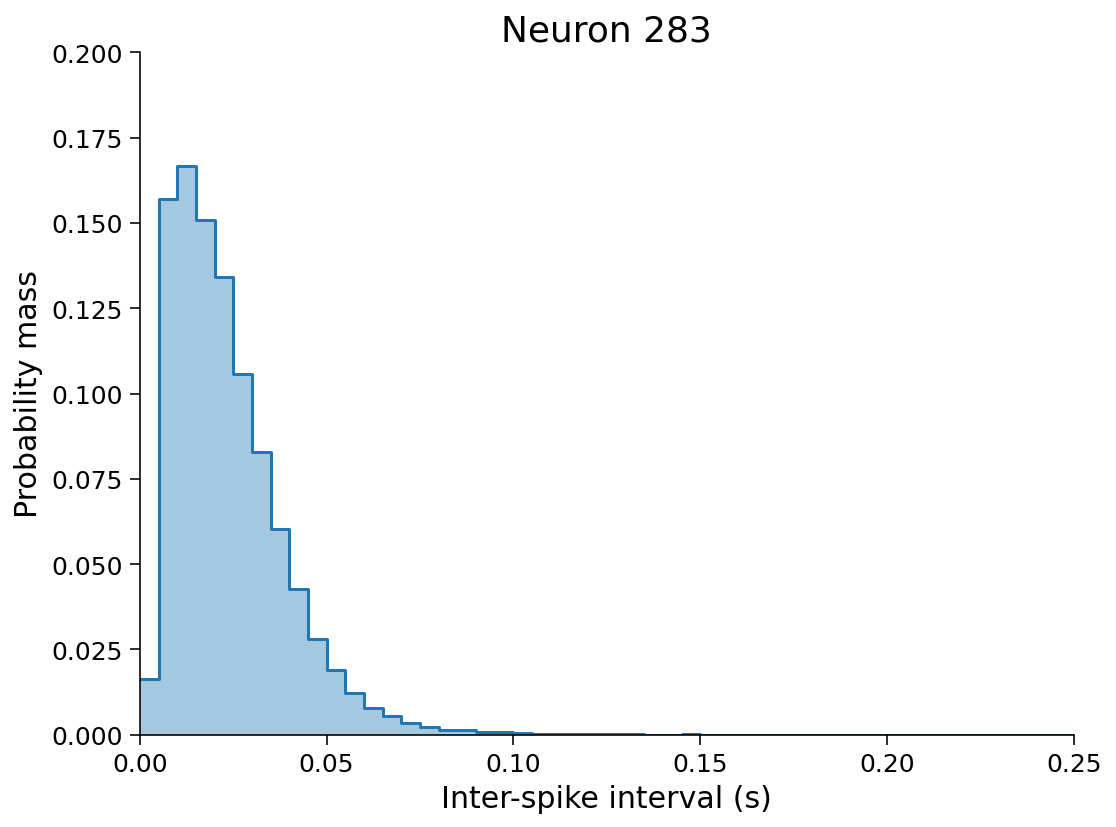

In [7]:
def pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""


  pmf = counts / np.sum(counts)

  return pmf


# Get neuron index
neuron_idx = 283

# Get counts of ISIs from Steinmetz data
isi = np.diff(steinmetz_spikes[neuron_idx])
bins = np.linspace(*isi_range, n_bins + 1)
counts, _ = np.histogram(isi, bins)

# Compute pmf
pmf = pmf_from_counts(counts)

# Visualize
plot_pmf(pmf, isi_range)

#### Calculate entropy from pmf
Now we have prob distribution can calculate entropy.

In [8]:
print(f"Entropy for Neuron {neuron_idx}: {entropy(pmf):.2f} bits")

Entropy for Neuron 283: 3.36 bits


Among all distributions (with fixed mean on positive numbers), exponential is the highest Entropy. So if make a big ISI bigger, forces other ISI's to be smaller, hence better to have more smaller instead of more bigger values
#### Summary
- Start with idea of what biology should optimize
- Hypothesize constraints and solve for best solution given constraints
- Check if coincides with measurements
Want to understand which behaviour would be optimal

#### Model's Summary
- __What__: describe data
- __How__: describe in terms of mechanisms
- __Why__: describe in terms of optimal solutions to constrained problems (that brain needs to solve)